In [1]:
# -*- coding: utf-8 -*-
import numpy as np
from scipy.linalg import cho_solve_banded, cholesky_banded, det, cholesky, norm
from timeit import default_timer as timer
from  matplotlib.pyplot import plot, xlabel
import matplotlib.pyplot as plt
from sys import getsizeof

# 1.A CHOLESKY DECOMPOSITION#


The most efficient direct method for solving the given linear system was found to be Cholesky decomposition, due to the special form of matrix A, which is banded, positive definite and symmetric. For the implementation below, the scipy.linalg module was used, since it comes with a ready-made function for the Cholesky decomposition of banded matrices, which is pretty fast.

In the section below the matrix construction is implemented. First we create the inner matrix B using the create_pentadiagonal function and then we move on to create the block banded matrix A using the create_block_pentadiagonal function. In the latter, in order to preserve memory, the intermediate matrices are deleted at each step, since they are all of size (nxn) which is prohibitive in terms of memory, especially in the third case where n = 128. 

It is easy to see that we took advantage of the repeating pattern in the A matrix in order to construct it in a more automated way using the Kronecker product of intermediate matrices. This method is efficient if the available memory is abundant but can be very slow for higher values of n, since both the matrices and their product have to be stored in-memory for each such calculation. In our case this problem becomes clear for n = 128, where the A matrix construction is pretty slow.

In order to make sure that the time measurements are as reliable as possible, the Python timeit module was used. However, since no Python timer is based on the CPU clock, but rather on the Windows clock, the time measurement error is  $\pm 1/60$ sec, which is pretty high.

In [2]:
# Creates B matrix
def create_pentadiagonal(n):
    # Creates the main (/2), second and third diagonals and then adds the transposed matrix to create B.
    ones = np.ones(n)
    main_diag = 3*ones
    second_diag = -4*ones[:-1]
    third_diag = ones[:-2]
    B = np.diag(main_diag) + np.diag(second_diag,1) + np.diag(third_diag,2)
    B = B + B.T
    return B
    
    
# Creates block matrix using Kronecker products to assign blocks to the right places
def create_block_pentadiagonal(n):
    I = np.eye(n)
    B = create_pentadiagonal(n)
    C = np.kron(I, 6*I + B)
    del B
    D = np.kron(np.diag(np.ones(n-1),1),-4*I)
    D = C + D + D.T
    del C
    F = np.kron(np.diag(np.ones(n-2),2),I)
    D = D + F + F.T
    return D

# Transforms banded matrix in the required form for scipy's Cholesky Decomposition
def create_banded(A):  
    n = int(np.sqrt(len(A)))
    
    # Creates a dictionary with keys the position of each diagonal in the upper right matrix and values the diagonal itself
    # The left offset is filled with zeros
    diagonals = {}
    diagonals[0] = np.diag(A)
    
    for i in range(1, 3*n + 1):
        diagonals[i] = np.concatenate([np.zeros(i), np.diag(A, i)], axis = 0)
    
    # Creates a numpy array by concatenating the diagonals in the correct order to create a matrix with zeros
    # in the upper left corner, from top to bottom
    upper = np.array([diagonals[i] for i in range(2*n, 0, -1)])
    
    # Concatenates the above result with the main diagonal, which is the final required compact form of the banded matrix
    banded = np.concatenate([
        upper,
        diagonals[0].reshape(1,n**2)],
        axis = 0       
        )
    
    return banded

In [3]:
# Given the Cholesky decomposition of A, solves the linear system

def SolveBanded(banded, b):
    cho_decomp =  cholesky_banded(banded, lower=False,check_finite=False)
    x = cho_solve_banded((cho_decomp, False), b)
    return x


In [4]:
all_n = [32, 64, 128]
construct_times = []
solve_times = []
mem_req = []
errors = []

for n in all_n:
    start = timer()
    A = create_block_pentadiagonal(n)
    A_banded = create_banded(A)
    b = np.ones(n**2).reshape(n**2,)
    end = timer()
    elapsed = end - start
    construct_times.append(elapsed)
    mem_req.append(getsizeof(A))

    print("Create all required matrices time for {0}x{0} matrix: {1} sec.".format(n, elapsed))
    
    start = timer()
    solution = SolveBanded(A_banded,b).reshape(n**2,)
    end = timer()
    elapsed = end - start
    solve_times.append(elapsed)
    err = norm(np.dot(A, solution) - b)
    errors.append(err)
    print("Solve the linear system time for {0}x{0} matrix: {1} sec.\n".format(n, elapsed))
    
    del A
    
# confirmation = np.dot(A,solution) - b

Create all required matrices time for 32x32 matrix: 0.06328204920776696 sec.
Solve the linear system time for 32x32 matrix: 0.03980800826840687 sec.

Create all required matrices time for 64x64 matrix: 1.1551120168096904 sec.
Solve the linear system time for 64x64 matrix: 0.01626755927145518 sec.

Create all required matrices time for 128x128 matrix: 87.53209878741906 sec.
Solve the linear system time for 128x128 matrix: 0.19579449845466002 sec.



# Matrices construction time (sec) against n plot

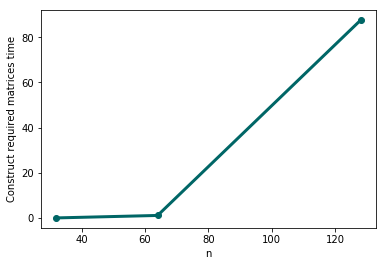

In [5]:
x = np.array(all_n)
y = np.array(construct_times)

plt.plot(x, y, color='#006666', marker='o',linewidth=3, markersize=6)
plt.xlabel('n')
plt.ylabel('Construct required matrices time')
plt.show()

It is evident that the matrix construction time rises exponentially as the n increases. It must be noted that the (128x128) matrix construction time is not consistent (it ranges from 17 sec to 70+ sec) and is therefore unreliable because it heavily depends on the machine's memory usage at the time. On an 8Gb RAM machine the function create_block_pentadiagonal reaches the RAM's limit which forces Python to find ways to make room in the memory. This procedure adds to the calculated elapsed time and not in a consistent manner. 

It must be noted that a similar implementation in Matlab for the matrix construction neither reached memory limit nor was as slow.

# Solve time (sec) against n plot

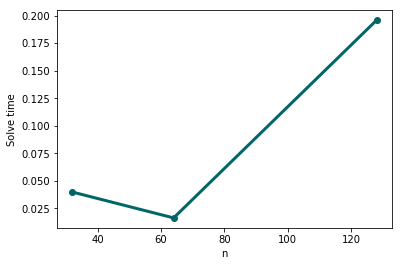

In [6]:
x = np.array(all_n)
y = np.array(solve_times)

plt.plot(x, y, color='#006666', marker='o',linewidth=3, markersize=6)
plt.xlabel('n')
plt.ylabel('Solve time')
plt.show()

We should point out that "Solve time" includes both the Cholesky decomposition and solving the upper triangular system. We can see that the Cholesky decomposition is impressively fast for all values of n. 

# Error against n plot

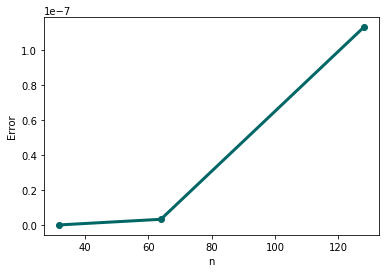

In [7]:
x = np.array(all_n)
y = np.array(errors)

plt.plot(x, y, color='#006666', marker='o',linewidth=3, markersize=6)
plt.xlabel('n')
plt.ylabel('Error')
plt.show()

Since it is easier to see a difference in absolute error than a difference in accuracy, the above plot describes the change in error as n increases. Of course, the accuracy would demonstrate the exact opposite behaviour. We can see that, as n increases, the error in the final solution increases exponentially, as expected.

# Memory requirements for A (bytes) against n plot

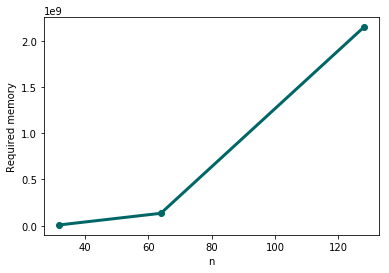

In [8]:
x = np.array(all_n)
y = np.array(mem_req)

plt.plot(x, y, color='#006666', marker='o',linewidth=3, markersize=6)
plt.xlabel('n')
plt.ylabel('Required memory')
plt.show()